In [5]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           average_precision_score, f1_score, precision_score, recall_score)

# Advanced ML libraries
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model interpretation
import shap

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [6]:
# Load the dataset
# Replace 'your_dataset.csv' with the actual path to your CSV file
df = pd.read_csv('Fraud.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (6362620, 11)

Column Names:
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

First few rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0           

In [7]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Check data types
print("\nData Types:")
print(df.dtypes)

# Target variable distribution
print("\nFraud Distribution:")
fraud_dist = df['isFraud'].value_counts()
print(fraud_dist)
print(f"\nFraud Rate: {df['isFraud'].mean():.4f} ({df['isFraud'].mean()*100:.2f}%)")

# Transaction type distribution
print("\nTransaction Type Distribution:")
type_dist = df['type'].value_counts()
print(type_dist)

Missing Values:
Series([], dtype: int64)

Data Types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Rate: 0.0013 (0.13%)

Transaction Type Distribution:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


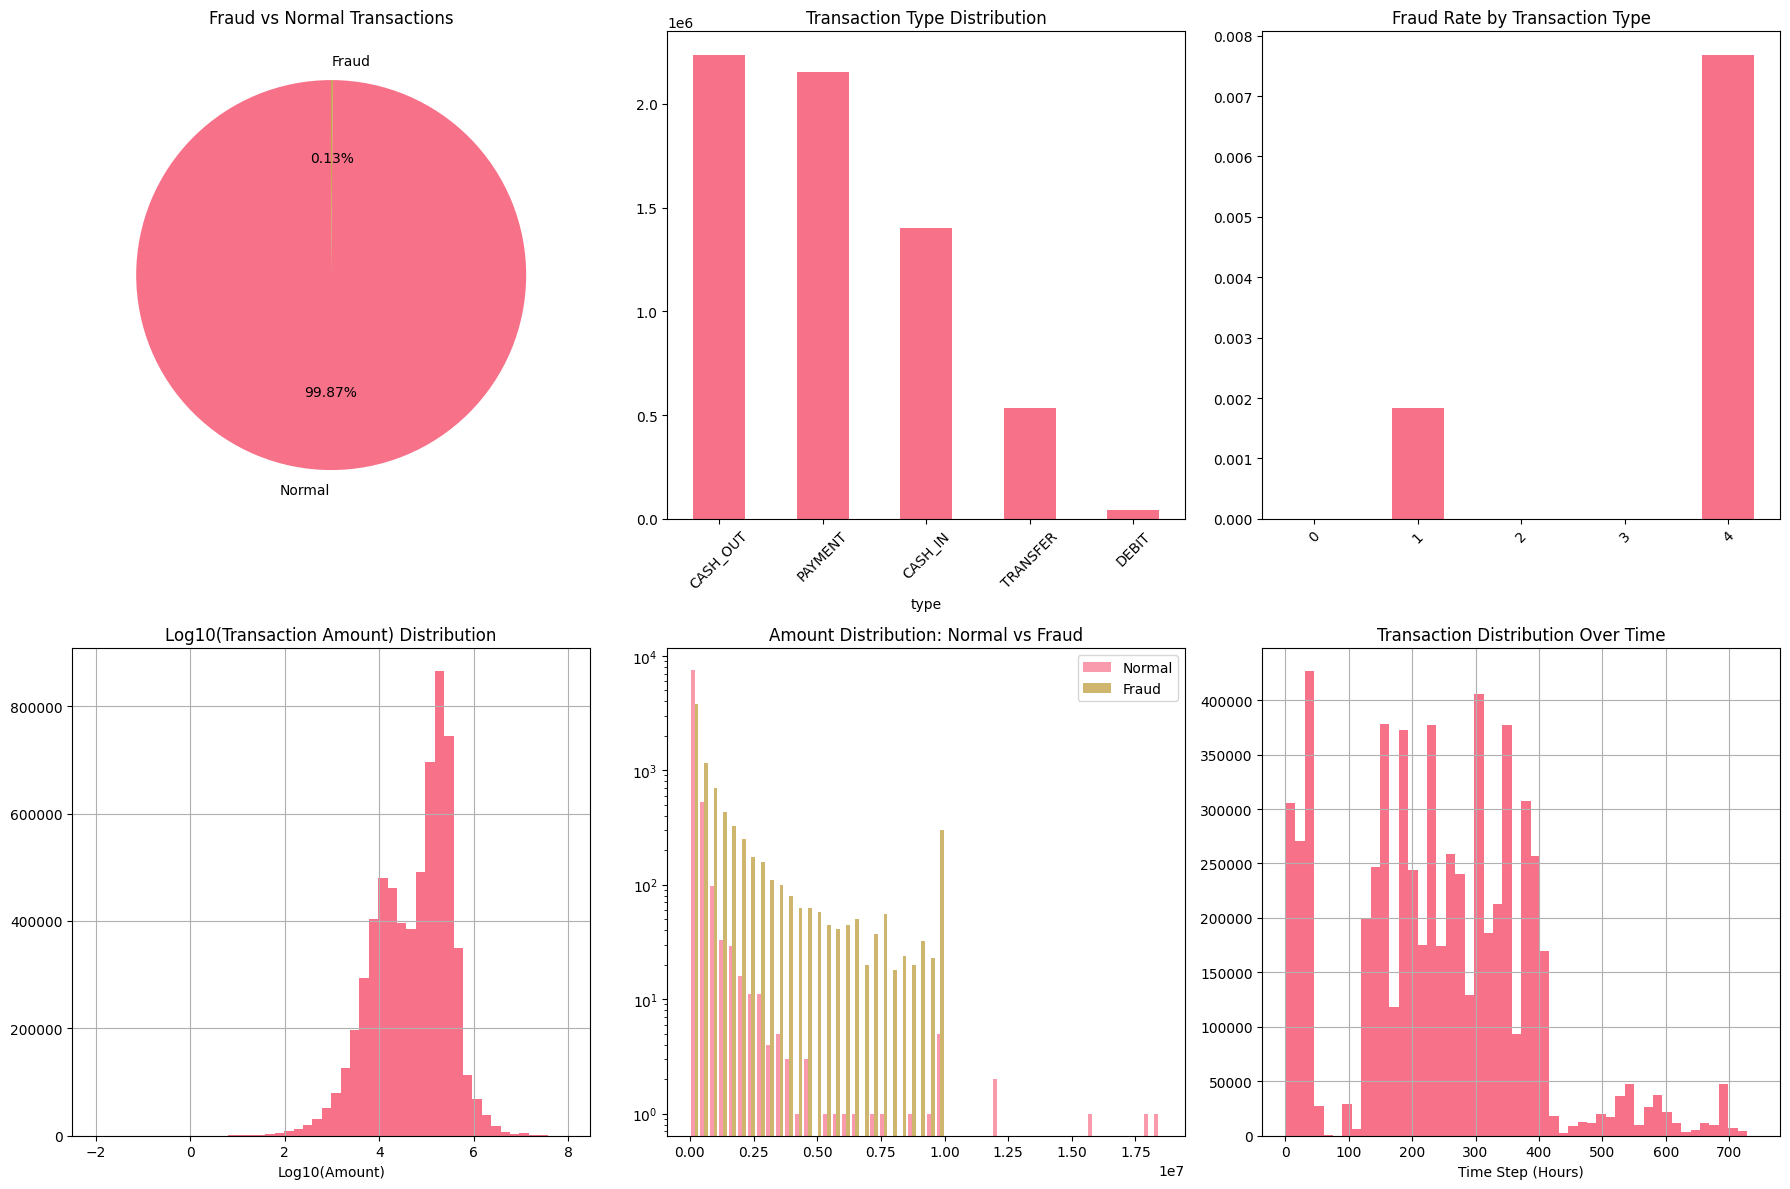

In [8]:
# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Fraud distribution
axes[0,0].pie(fraud_dist.values, labels=['Normal', 'Fraud'], autopct='%1.2f%%', startangle=90)
axes[0,0].set_title('Fraud vs Normal Transactions')

# 2. Transaction type distribution
type_dist.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Transaction Type Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum']).reset_index()
fraud_by_type['fraud_rate'] = fraud_by_type['sum'] / fraud_by_type['count']
fraud_by_type['fraud_rate'].plot(kind='bar', ax=axes[0,2])
axes[0,2].set_title('Fraud Rate by Transaction Type')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Amount distribution (log scale due to wide range)
df[df['amount'] > 0]['amount'].apply(np.log10).hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Log10(Transaction Amount) Distribution')
axes[1,0].set_xlabel('Log10(Amount)')

# 5. Amount distribution for fraud vs normal
fraud_amounts = df[df['isFraud'] == 1]['amount']
normal_amounts = df[df['isFraud'] == 0]['amount'].sample(len(fraud_amounts))
axes[1,1].hist([normal_amounts, fraud_amounts], bins=50, alpha=0.7, label=['Normal', 'Fraud'])
axes[1,1].set_title('Amount Distribution: Normal vs Fraud')
axes[1,1].legend()
axes[1,1].set_yscale('log')

# 6. Time distribution
df['step'].hist(bins=50, ax=axes[1,2])
axes[1,2].set_title('Transaction Distribution Over Time')
axes[1,2].set_xlabel('Time Step (Hours)')

plt.tight_layout()
plt.show()

In [9]:
print("FRAUD PATTERN ANALYSIS")
print("=" * 50)

# Fraud by transaction type - detailed
fraud_analysis = df.groupby('type').agg({
    'isFraud': ['count', 'sum', 'mean'],
    'amount': ['mean', 'median', 'max']
}).round(4)

fraud_analysis.columns = ['_'.join(col).strip() for col in fraud_analysis.columns]
print("Fraud Analysis by Transaction Type:")
print(fraud_analysis)

# Check for merchants (customers starting with 'M')
df['is_merchant_dest'] = df['nameDest'].str.startswith('M')
df['is_merchant_orig'] = df['nameOrig'].str.startswith('M')

print(f"\nMerchant Destination Transactions: {df['is_merchant_dest'].sum()}")
print(f"Merchant Origin Transactions: {df['is_merchant_orig'].sum()}")

# Analyze balance patterns
print("\nBalance Pattern Analysis:")
df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Check for zero balances after transactions (potential account draining)
df['zero_balance_after_orig'] = (df['newbalanceOrig'] == 0) & (df['oldbalanceOrg'] > 0)
print(f"Transactions resulting in zero balance (origin): {df['zero_balance_after_orig'].sum()}")

fraud_zero_balance = df[df['zero_balance_after_orig'] == True]['isFraud'].mean()
print(f"Fraud rate when origin balance becomes zero: {fraud_zero_balance:.4f}")


FRAUD PATTERN ANALYSIS
Fraud Analysis by Transaction Type:
          isFraud_count  isFraud_sum  isFraud_mean  amount_mean  \
type                                                              
CASH_IN         1399284            0        0.0000  168920.2420   
CASH_OUT        2237500         4116        0.0018  176273.9643   
DEBIT             41432            0        0.0000    5483.6653   
PAYMENT         2151495            0        0.0000   13057.6047   
TRANSFER         532909         4097        0.0077  910647.0096   

          amount_median   amount_max  
type                                  
CASH_IN      143427.710   1915267.90  
CASH_OUT     147072.185  10000000.00  
DEBIT          3048.990    569077.51  
PAYMENT        9482.190    238637.98  
TRANSFER     486308.390  92445516.64  

Merchant Destination Transactions: 2151495
Merchant Origin Transactions: 0

Balance Pattern Analysis:
Transactions resulting in zero balance (origin): 1520581
Fraud rate when origin balance becomes

In [10]:
print("FEATURE ENGINEERING")
print("=" * 50)

def create_features(df):
    """Create new features for fraud detection"""
    df_new = df.copy()
    
    # Balance-based features
    df_new['balance_change_orig'] = df_new['newbalanceOrig'] - df_new['oldbalanceOrg']
    df_new['balance_change_dest'] = df_new['newbalanceDest'] - df_new['oldbalanceDest']
    
    # Ratio features (add small constant to avoid division by zero)
    df_new['amount_to_oldbalance_orig_ratio'] = df_new['amount'] / (df_new['oldbalanceOrg'] + 1)
    df_new['amount_to_oldbalance_dest_ratio'] = df_new['amount'] / (df_new['oldbalanceDest'] + 1)
    
    # Boolean features
    df_new['is_merchant_dest'] = df_new['nameDest'].str.startswith('M').astype(int)
    df_new['is_merchant_orig'] = df_new['nameOrig'].str.startswith('M').astype(int)
    df_new['zero_balance_after_orig'] = ((df_new['newbalanceOrig'] == 0) & (df_new['oldbalanceOrg'] > 0)).astype(int)
    df_new['zero_balance_after_dest'] = ((df_new['newbalanceDest'] == 0) & (df_new['oldbalanceDest'] > 0)).astype(int)
    df_new['zero_balance_before_orig'] = (df_new['oldbalanceOrg'] == 0).astype(int)
    df_new['zero_balance_before_dest'] = (df_new['oldbalanceDest'] == 0).astype(int)
    
    # Amount-based features
    df_new['is_round_amount'] = (df_new['amount'] % 10000 == 0).astype(int)
    df_new['amount_log'] = np.log10(df_new['amount'] + 1)
    
    # Time-based features
    df_new['hour_of_day'] = df_new['step'] % 24
    df_new['day_of_month'] = df_new['step'] // 24
    
    # Transaction type encoding
    df_new = pd.get_dummies(df_new, columns=['type'], prefix='type')
    
    return df_new

# Apply feature engineering
df_features = create_features(df)

print("New features created:")
new_features = [col for col in df_features.columns if col not in df.columns]
print(new_features)

print(f"\nDataset shape after feature engineering: {df_features.shape}")


FEATURE ENGINEERING
New features created:
['amount_to_oldbalance_orig_ratio', 'amount_to_oldbalance_dest_ratio', 'zero_balance_after_dest', 'zero_balance_before_orig', 'zero_balance_before_dest', 'is_round_amount', 'amount_log', 'hour_of_day', 'day_of_month', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

Dataset shape after feature engineering: (6362620, 29)


In [11]:
print("DATA PREPROCESSING")
print("=" * 50)

# Check for missing values in new dataset
missing_after_features = df_features.isnull().sum()
print("Missing values after feature engineering:")
print(missing_after_features[missing_after_features > 0])

# Handle infinite values from ratio calculations
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(0)

# Select features for modeling (exclude string columns and target)
exclude_cols = ['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

X = df_features[feature_cols]
y = df_features['isFraud']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features selected: {len(feature_cols)}")

# Check for multicollinearity
correlation_matrix = X.corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  correlation_matrix.iloc[i, j]))

print(f"\nHighly correlated feature pairs (>0.9): {len(high_corr_pairs)}")
for pair in high_corr_pairs[:5]:  # Show first 5
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


DATA PREPROCESSING
Missing values after feature engineering:
Series([], dtype: int64)
Feature matrix shape: (6362620, 25)
Target vector shape: (6362620,)
Features selected: 25

Highly correlated feature pairs (>0.9): 4
step - day_of_month: 1.000
oldbalanceOrg - newbalanceOrig: 0.999
oldbalanceDest - newbalanceDest: 0.977
is_merchant_dest - type_PAYMENT: 1.000


In [13]:
print("TRAIN-TEST SPLIT")
print("=" * 50)

# Stratified split to maintain fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")


TRAIN-TEST SPLIT
Training set shape: (4453834, 25)
Test set shape: (1908786, 25)
Training fraud rate: 0.0013
Test fraud rate: 0.0013
Feature scaling completed!


In [14]:
print("BASELINE MODEL TRAINING")
print("=" * 50)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-validation results
cv_results = {}
cv_folds = 5

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for logistic regression, original for tree-based models
    if name == 'Logistic Regression':
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_cv, y_train, cv=cv_folds, 
                               scoring='roc_auc', n_jobs=-1)
    
    cv_results[name] = {
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"{name} - CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final models and get test predictions
model_results = {}

for name, model in models.items():
    print(f"\nFinal training for {name}...")
    
    # Use appropriate data
    if name == 'Logistic Regression':
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
    else:
        X_train_final = X_train
        X_test_final = X_test
    
    # Train model
    model.fit(X_train_final, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


BASELINE MODEL TRAINING

Training Logistic Regression...
Logistic Regression - CV AUC: nan (+/- nan)

Training Decision Tree...
Decision Tree - CV AUC: 0.9947 (+/- 0.0030)

Training Random Forest...
Random Forest - CV AUC: 0.9992 (+/- 0.0008)

Training XGBoost...
XGBoost - CV AUC: 0.9740 (+/- 0.0506)

Final training for Logistic Regression...
AUC: 0.9942, Precision: 0.9066, Recall: 0.5434, F1: 0.6795

Final training for Decision Tree...
AUC: 0.9950, Precision: 0.9876, Recall: 0.8097, F1: 0.8898

Final training for Random Forest...
AUC: 0.9992, Precision: 1.0000, Recall: 0.8596, F1: 0.9245

Final training for XGBoost...
AUC: 0.9897, Precision: 0.9476, Recall: 0.9168, F1: 0.9319


MODEL PERFORMANCE COMPARISON
                 Model     AUC  Precision  Recall  F1-Score
0  Logistic Regression  0.9942     0.9066  0.5434    0.6795
1        Decision Tree  0.9950     0.9876  0.8097    0.8898
2        Random Forest  0.9992     1.0000  0.8596    0.9245
3              XGBoost  0.9897     0.9476  0.9168    0.9319


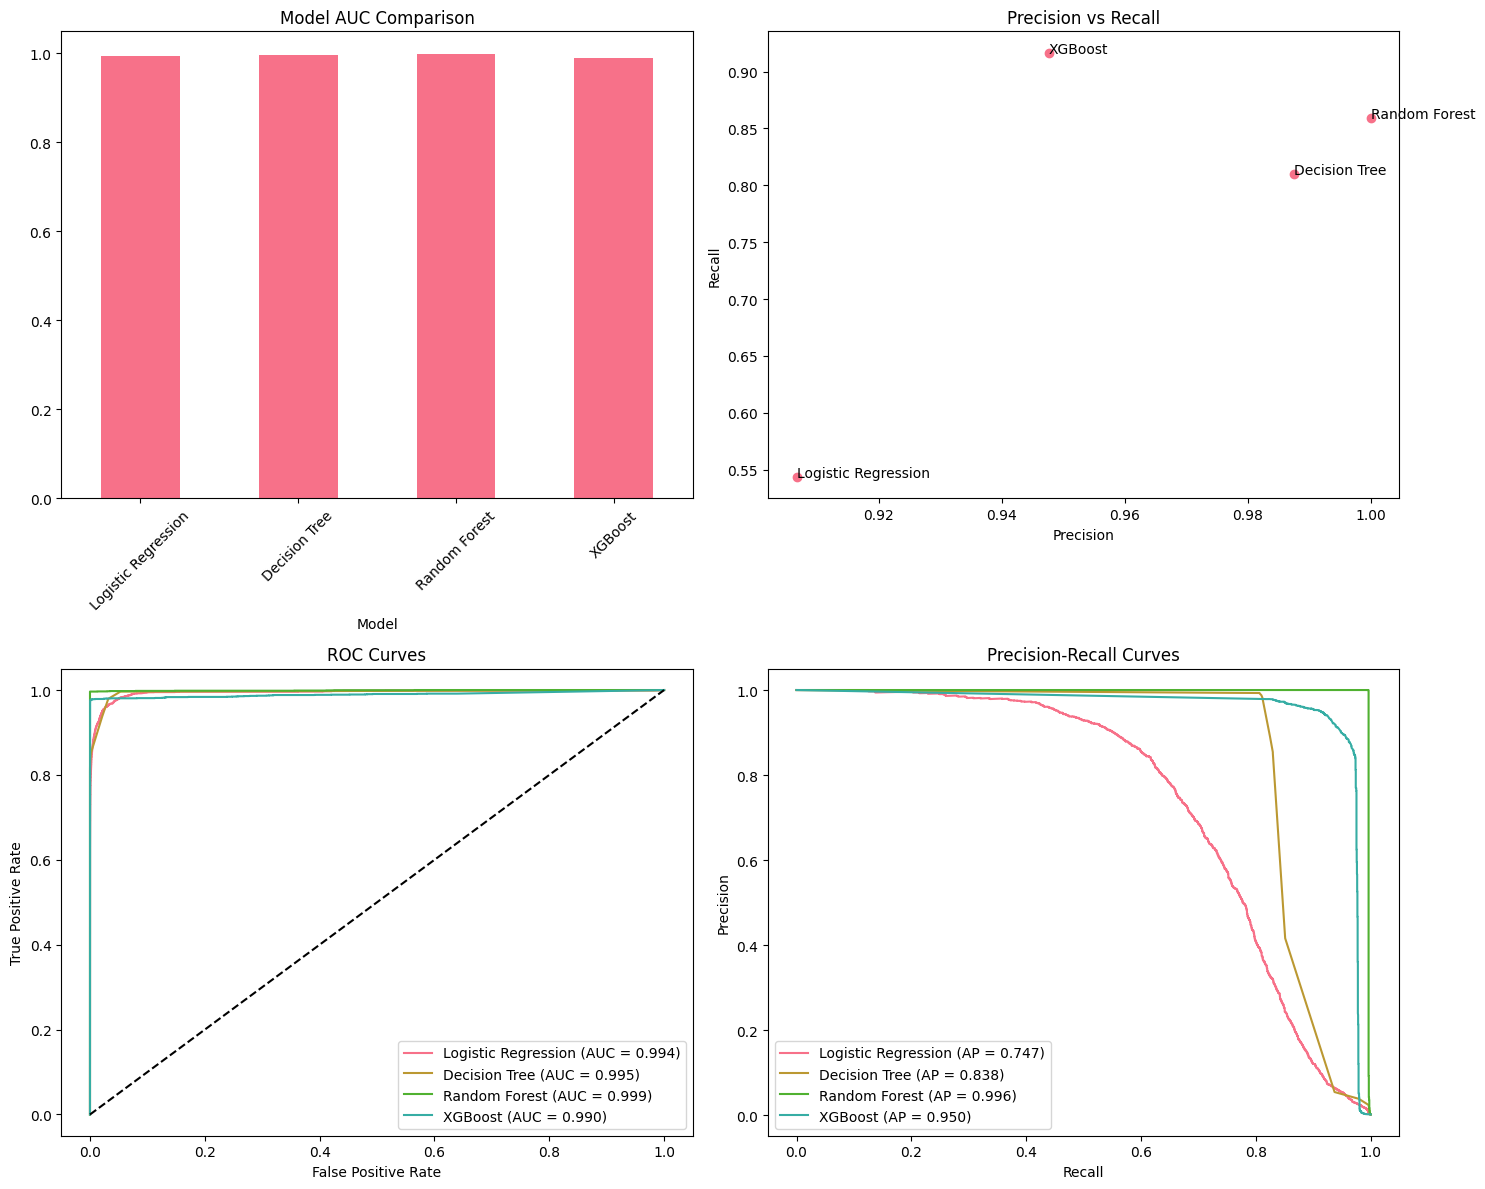

In [15]:
print("MODEL PERFORMANCE COMPARISON")
print("=" * 50)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'AUC': [results['auc'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1'] for results in model_results.values()]
}).round(4)

print(comparison_df)

# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC comparison
comparison_df.set_index('Model')['AUC'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Model AUC Comparison')
axes[0,0].tick_params(axis='x', rotation=45)

# Precision-Recall comparison
axes[0,1].scatter(comparison_df['Precision'], comparison_df['Recall'])
for i, model in enumerate(comparison_df['Model']):
    axes[0,1].annotate(model, (comparison_df['Precision'].iloc[i], comparison_df['Recall'].iloc[i]))
axes[0,1].set_xlabel('Precision')
axes[0,1].set_ylabel('Recall')
axes[0,1].set_title('Precision vs Recall')

# ROC Curves
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    axes[1,0].plot(fpr, tpr, label=f"{name} (AUC = {results['auc']:.3f})")

axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves')
axes[1,0].legend()

# Precision-Recall Curves
for name, results in model_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
    avg_precision = average_precision_score(y_test, results['y_pred_proba'])
    axes[1,1].plot(recall, precision, label=f"{name} (AP = {avg_precision:.3f})")

axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curves')
axes[1,1].legend()

plt.tight_layout()
plt.show()


BEST MODEL: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.86      0.92      2464

    accuracy                           1.00   1908786
   macro avg       1.00      0.93      0.96   1908786
weighted avg       1.00      1.00      1.00   1908786



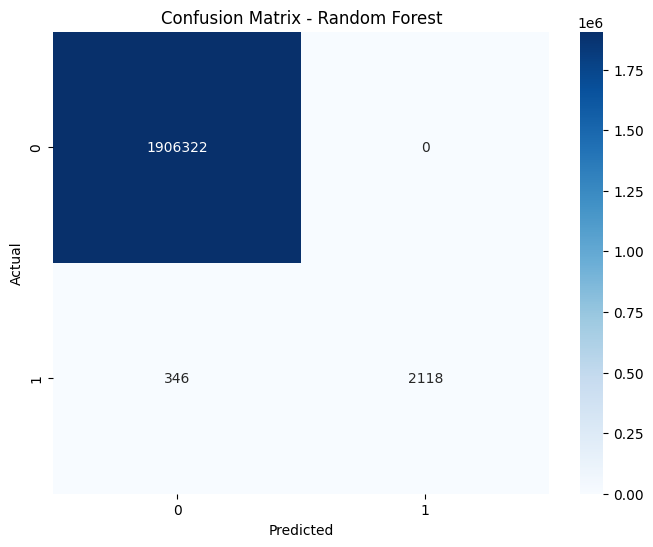


Confusion Matrix Analysis:
True Negatives: 1906322
False Positives: 0
False Negatives: 346
True Positives: 2118
False Positive Rate: 0.0000
False Negative Rate: 0.1404


In [16]:
# Select best model based on AUC
best_model_name = comparison_df.loc[comparison_df['AUC'].idxmax(), 'Model']
best_model_results = model_results[best_model_name]
best_model = best_model_results['model']

print(f"BEST MODEL: {best_model_name}")
print("=" * 50)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, best_model_results['y_pred']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_model_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"\nConfusion Matrix Analysis:")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")


FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
                            feature  importance
11  amount_to_oldbalance_orig_ratio    0.286596
8               balance_change_orig    0.259609
2                     oldbalanceOrg    0.063838
5                    newbalanceDest    0.063182
10          zero_balance_after_orig    0.059380
9               balance_change_dest    0.046794
0                              step    0.031501
3                    newbalanceOrig    0.030565
12  amount_to_oldbalance_dest_ratio    0.028189
19                     day_of_month    0.026929
24                    type_TRANSFER    0.020793
18                      hour_of_day    0.014941
21                    type_CASH_OUT    0.014260
1                            amount    0.012731
17                       amount_log    0.011368


<Figure size 1000x800 with 0 Axes>

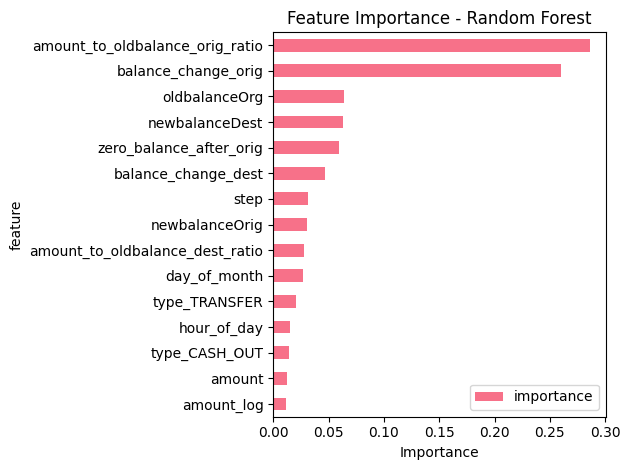

In [17]:
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance (works for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    feature_importance.head(15).plot(x='feature', y='importance', kind='barh')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# For logistic regression, show coefficients
elif hasattr(best_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': best_model.coef_[0],
        'abs_coefficient': np.abs(best_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("Top 15 Most Important Features (by coefficient magnitude):")
    print(feature_coef.head(15))
    
    # Plot coefficients
    plt.figure(figsize=(10, 8))
    top_features = feature_coef.head(15)
    plt.barh(range(len(top_features)), top_features['coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


SHAP ANALYSIS


<Figure size 1000x800 with 0 Axes>

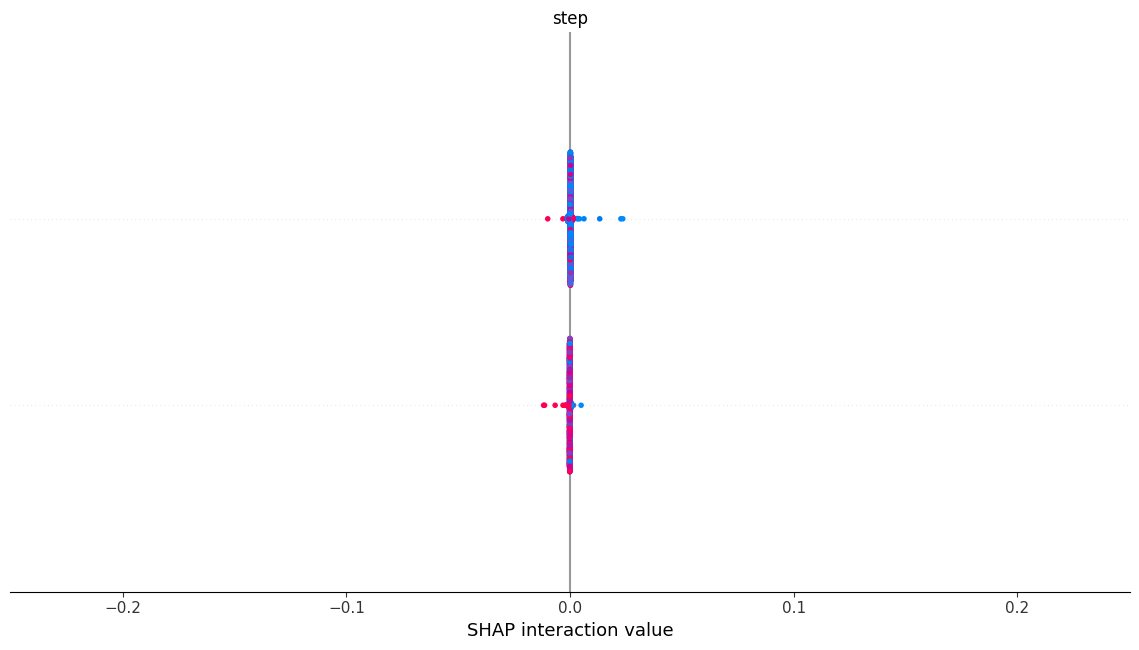

SHAP analysis completed - see plot above


In [18]:
print("SHAP ANALYSIS")
print("=" * 50)

try:
    # Create SHAP explainer (works well with tree-based models)
    if best_model_name in ['Random Forest', 'XGBoost']:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test.iloc[:1000])  # Use subset for speed
        
        # If binary classification returns two arrays, use the positive class
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test.iloc[:1000], show=False)
        plt.tight_layout()
        plt.show()
        
        print("SHAP analysis completed - see plot above")
        
    else:
        print("SHAP analysis skipped - not compatible with selected model")
        
except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")


In [19]:
print("BUSINESS IMPACT ANALYSIS")
print("=" * 50)

# Calculate business metrics
total_transactions = len(y_test)
total_fraud_transactions = y_test.sum()
total_normal_transactions = total_transactions - total_fraud_transactions

# Model predictions
predicted_fraud = best_model_results['y_pred'].sum()
predicted_normal = total_transactions - predicted_fraud

# True/False Positives/Negatives
tp = ((y_test == 1) & (best_model_results['y_pred'] == 1)).sum()
fp = ((y_test == 0) & (best_model_results['y_pred'] == 1)).sum()
tn = ((y_test == 0) & (best_model_results['y_pred'] == 0)).sum()
fn = ((y_test == 1) & (best_model_results['y_pred'] == 0)).sum()

print("Business Metrics:")
print(f"Total Transactions Tested: {total_transactions:,}")
print(f"Actual Fraud Transactions: {total_fraud_transactions:,}")
print(f"Predicted Fraud Transactions: {predicted_fraud:,}")
print(f"\nDetection Performance:")
print(f"Frauds Caught: {tp:,} out of {total_fraud_transactions:,} ({tp/total_fraud_transactions*100:.1f}%)")
print(f"Frauds Missed: {fn:,} ({fn/total_fraud_transactions*100:.1f}%)")
print(f"False Alarms: {fp:,} out of {total_normal_transactions:,} ({fp/total_normal_transactions*100:.2f}%)")

# Assume average fraud transaction amount for impact calculation
avg_fraud_amount = df[df['isFraud'] == 1]['amount'].mean()
print(f"\nEstimated Financial Impact:")
print(f"Average Fraud Transaction: ${avg_fraud_amount:,.2f}")
print(f"Fraud Prevented: ${tp * avg_fraud_amount:,.2f}")
print(f"Fraud Missed: ${fn * avg_fraud_amount:,.2f}")

BUSINESS IMPACT ANALYSIS
Business Metrics:
Total Transactions Tested: 1,908,786
Actual Fraud Transactions: 2,464
Predicted Fraud Transactions: 2,118

Detection Performance:
Frauds Caught: 2,118 out of 2,464 (86.0%)
Frauds Missed: 346 (14.0%)
False Alarms: 0 out of 1,906,322 (0.00%)

Estimated Financial Impact:
Average Fraud Transaction: $1,467,967.30
Fraud Prevented: $3,109,154,739.58
Fraud Missed: $507,916,685.50


In [20]:
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("=" * 50)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape[0]} samples")
print(f"Balanced training set: {X_train_balanced.shape[0]} samples")
print(f"Original fraud rate: {y_train.mean():.4f}")
print(f"Balanced fraud rate: {y_train_balanced.mean():.4f}")

# Train model on balanced data
if best_model_name == 'XGBoost':
    balanced_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
elif best_model_name == 'Random Forest':
    balanced_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
else:
    balanced_model = best_model.__class__(**best_model.get_params())

balanced_model.fit(X_train_balanced, y_train_balanced)

# Evaluate balanced model
y_pred_balanced = balanced_model.predict(X_test)
y_pred_proba_balanced = balanced_model.predict_proba(X_test)[:, 1]

auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)

print(f"\nBalanced Model Performance:")
print(f"AUC: {auc_balanced:.4f}")
print(f"Precision: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")
print(f"F1-Score: {f1_balanced:.4f}")

print(f"\nComparison with Original Model:")
print(f"AUC: {best_model_results['auc']:.4f} -> {auc_balanced:.4f}")
print(f"Precision: {best_model_results['precision']:.4f} -> {precision_balanced:.4f}")
print(f"Recall: {best_model_results['recall']:.4f} -> {recall_balanced:.4f}")
print(f"F1: {best_model_results['f1']:.4f} -> {f1_balanced:.4f}")


HANDLING CLASS IMBALANCE WITH SMOTE
Original training set: 4453834 samples
Balanced training set: 8896170 samples
Original fraud rate: 0.0013
Balanced fraud rate: 0.5000

Balanced Model Performance:
AUC: 0.9999
Precision: 0.9627
Recall: 0.9963
F1-Score: 0.9793

Comparison with Original Model:
AUC: 0.9992 -> 0.9999
Precision: 1.0000 -> 0.9627
Recall: 0.8596 -> 0.9963
F1: 0.9245 -> 0.9793


THRESHOLD OPTIMIZATION
Using SMOTE-balanced model for threshold optimization
Optimal threshold based on F1-score: 0.8000000000000002


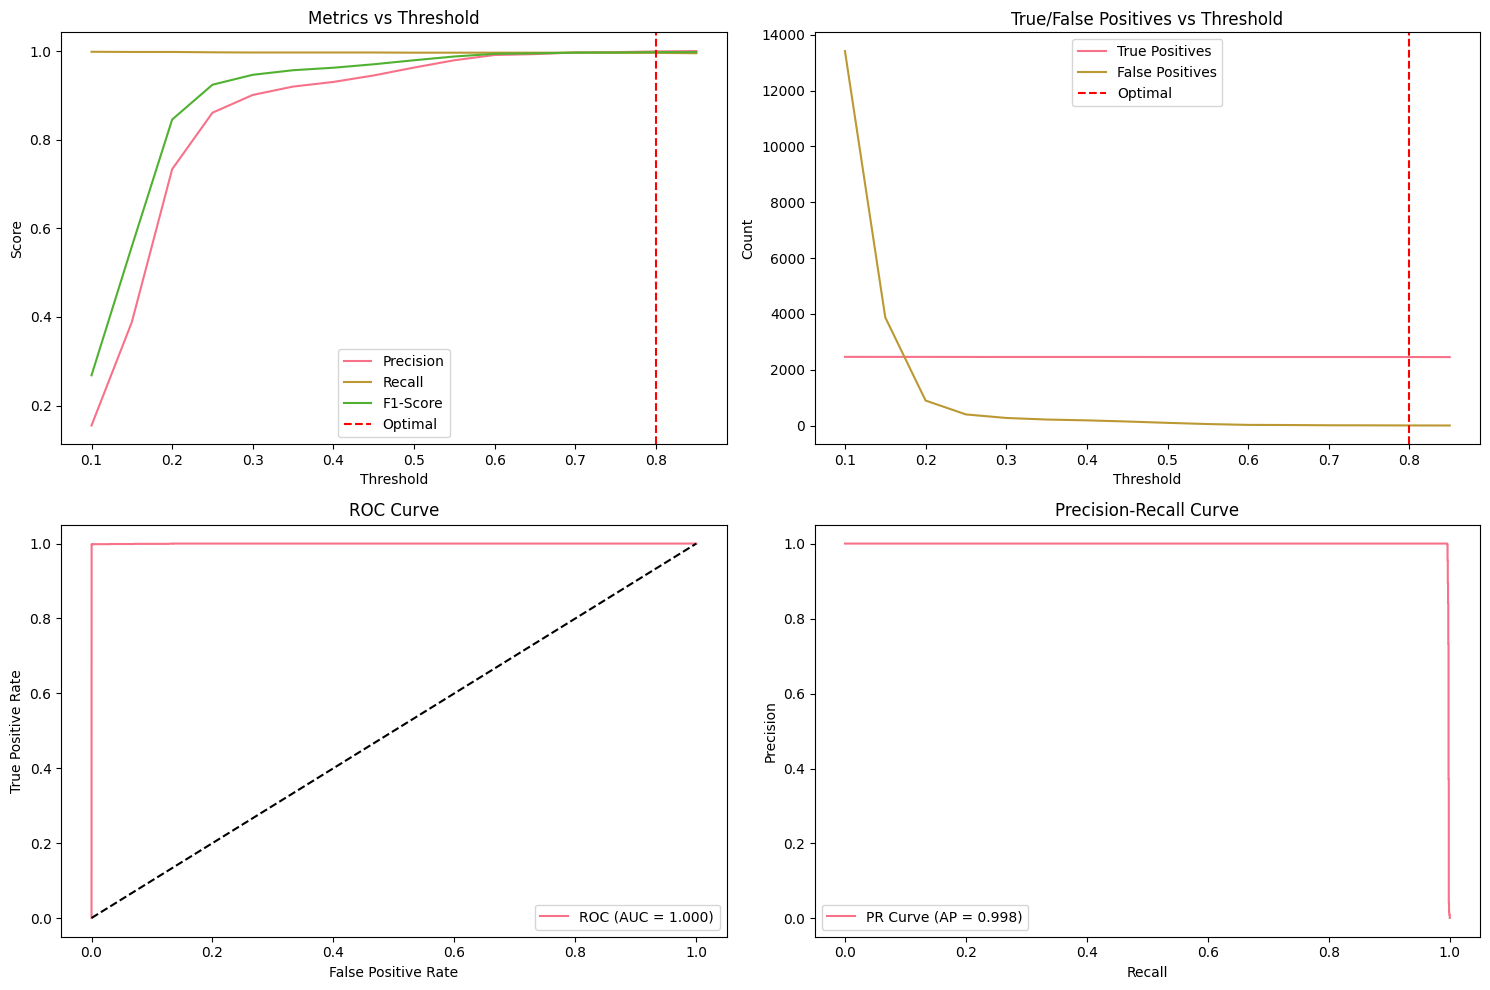

In [22]:
print("THRESHOLD OPTIMIZATION")
print("=" * 50)

# Use the better performing model
if f1_balanced > best_model_results['f1']:
    final_model = balanced_model
    final_proba = y_pred_proba_balanced
    print("Using SMOTE-balanced model for threshold optimization")
else:
    final_model = best_model
    final_proba = best_model_results['y_pred_proba']
    print("Using original model for threshold optimization")

# Calculate metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (final_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    # Calculate business metrics
    tp = ((y_test == 1) & (y_pred_thresh == 1)).sum()
    fp = ((y_test == 0) & (y_pred_thresh == 1)).sum()
    
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold based on F1 score
optimal_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
print(f"Optimal threshold based on F1-score: {optimal_threshold}")

# Plot threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(threshold_df['threshold'], threshold_df['precision'], label='Precision')
axes[0,0].plot(threshold_df['threshold'], threshold_df['recall'], label='Recall')
axes[0,0].plot(threshold_df['threshold'], threshold_df['f1'], label='F1-Score')
axes[0,0].axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal')
axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Metrics vs Threshold')
axes[0,0].legend()

axes[0,1].plot(threshold_df['threshold'], threshold_df['tp'], label='True Positives')
axes[0,1].plot(threshold_df['threshold'], threshold_df['fp'], label='False Positives')
axes[0,1].axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal')
axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('True/False Positives vs Threshold')
axes[0,1].legend()

# ROC and PR curves for final model
fpr, tpr, _ = roc_curve(y_test, final_proba)
axes[1,0].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, final_proba):.3f})')
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()

precision, recall, _ = precision_recall_curve(y_test, final_proba)
avg_precision = average_precision_score(y_test, final_proba)
axes[1,1].plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.3f})')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve')
axes[1,1].legend()

plt.tight_layout()
plt.show()